<a href="https://colab.research.google.com/github/nissrinayy/deeplearning/blob/main/Week3/week3_1_CNN_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from torch.utils.data import DataLoader

In [ ]:
# Augmentasi Data untuk CNN
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Flip secara horizontal
    transforms.RandomRotation(10),      # Rotasi hingga 10 derajat
    transforms.RandomCrop(32, padding=4), # Crop dengan padding
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [ ]:
# Load Dataset CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

In [ ]:
# Cek sample data
classes = trainset.classes
print("Classes:", classes)

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 2048)  # Tambah Neuron
        self.bn1 = nn.BatchNorm1d(2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return x


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Dropout untuk Regularisasi

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience  # Jumlah epoch sebelum berhenti
        self.best_acc = 0
        self.counter = 0

    def check(self, acc):
        if acc > self.best_acc:
            self.best_acc = acc
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience  # Jika counter mencapai patience, stop training


In [ ]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=20):
    model.to(device)  # Pindahkan model ke GPU
    model.train()
    train_losses = []
    train_accuracies = []
    early_stopping = EarlyStopping(patience=5)  # **Deklarasikan di dalam fungsi**

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)  # Pindahkan data ke GPU

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Hitung training loss
            running_loss += loss.item()

            # Hitung training accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # Update scheduler jika digunakan
        if scheduler:
            scheduler.step()

        # Simpan loss dan akurasi
        avg_loss = running_loss / len(trainloader)
        train_accuracy = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(train_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

        # **Cek Early Stopping**
        if early_stopping.check(train_accuracy):
            print(f"Early stopping at epoch {epoch+1}")
            break  # Hentikan training

    return train_losses, train_accuracies


In [ ]:
def evaluate_model(model):
    model.to(device)  # Pindahkan model ke GPU
    model.eval()
    y_true, y_pred = [], []
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)  # Pindahkan data ke GPU
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())  # Kembalikan ke CPU sebelum diproses sklearn
            y_pred.extend(predicted.cpu().numpy())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Hitung akurasi testing
    test_accuracy = correct / total
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f"\nTesting Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Training CNN
cnn_model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(cnn_model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

print("\nTraining CNN with Early Stopping...")
train_losses, train_accuracies = train_model(cnn_model, criterion, optimizer, scheduler, num_epochs=20)

print("\nEvaluating CNN Model...")
evaluate_model(cnn_model)

# Training MLP
mlp_model = MLP().to(device)
optimizer = optim.AdamW(mlp_model.parameters(), lr=0.001, weight_decay=0.01)

print("\nTraining MLP with Early Stopping...")
train_losses, train_accuracies = train_model(mlp_model, criterion, optimizer, scheduler, num_epochs=20)

print("\nEvaluating MLP Model...")
evaluate_model(mlp_model)


Using device: cuda

Training CNN with Early Stopping...
Epoch 1/20, Loss: 1.5718, Training Accuracy: 0.4184, LR: 0.001000
Epoch 2/20, Loss: 1.2161, Training Accuracy: 0.5634, LR: 0.001000
Epoch 3/20, Loss: 1.0306, Training Accuracy: 0.6325, LR: 0.001000
Epoch 4/20, Loss: 0.9182, Training Accuracy: 0.6773, LR: 0.001000
Epoch 5/20, Loss: 0.8400, Training Accuracy: 0.7058, LR: 0.000500
Epoch 6/20, Loss: 0.7433, Training Accuracy: 0.7403, LR: 0.000500
Epoch 7/20, Loss: 0.7036, Training Accuracy: 0.7534, LR: 0.000500
Epoch 8/20, Loss: 0.6795, Training Accuracy: 0.7610, LR: 0.000500
Epoch 9/20, Loss: 0.6600, Training Accuracy: 0.7698, LR: 0.000500
Epoch 10/20, Loss: 0.6410, Training Accuracy: 0.7762, LR: 0.000250
Epoch 11/20, Loss: 0.5897, Training Accuracy: 0.7952, LR: 0.000250
Epoch 12/20, Loss: 0.5779, Training Accuracy: 0.7973, LR: 0.000250
Epoch 13/20, Loss: 0.5647, Training Accuracy: 0.8018, LR: 0.000250
Epoch 14/20, Loss: 0.5582, Training Accuracy: 0.8049, LR: 0.000250
Epoch 15/20, Lo

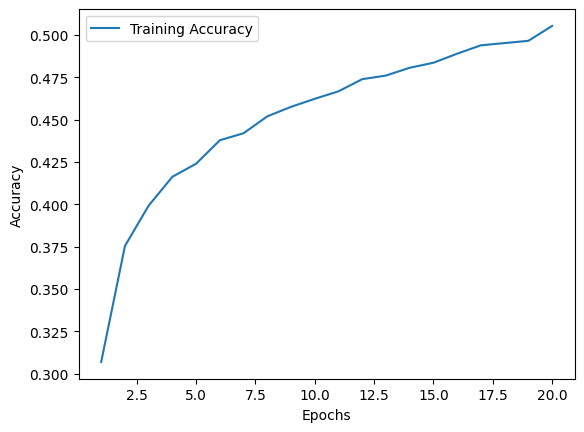

In [ ]:
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
